In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import pickle

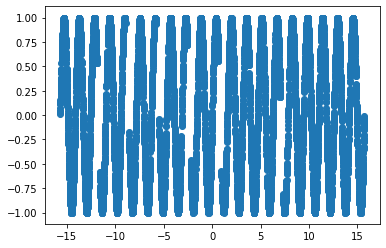

In [27]:
N=10000
nodes = 50
epochs = 10000
Hidden_layers = 6
validation_fraction = 0.1 #fraction of data used for validaiton. Should be between 0.1 and 0.2
learning_rate=0.001
beta_1=0.9995 
beta_2=0.999 
epsilon=1e-9
#regularization = 0.001
regularization = False
#regularization = 1e-5

x_range=[-5*np.pi,5*np.pi]
period=0.5*np.pi

#Optimal_learning rate: ~ 0.004 - 0.001
#Optima_regularization: ~ 1e-5 - 1e-6
#Optimal_epochs = ~ 10,000 - 100,000
'''
Default parameters follow those provided in the paper. It is recommended to leave the parameters of this optimizer at their default values.
learning_rate: float >= 0. Learning rate.
beta_1: float, 0 < beta < 1. Generally close to 1.
beta_2: float, 0 < beta < 1. Generally close to 1.
'''

x_data =np.random.rand(N)*(x_range[1]-x_range[0])+x_range[0]
y_data =np.sin(x_data*(2*np.pi/period))

x_data, y_data = (list(t) for t in zip(*sorted(zip(x_data, y_data))))

sects = [[0.12,0.01],[0.22,0.01],[0.32,0.01],[0.42,0.01],[0.52,0.01],[0.72,0.01]]
sections2remove = []
gap_ranges = []
for i in range(len(sects)):
    sections2remove+=list(range(int(sects[i][0]*N),int((sects[i][0]*N)+sects[i][1]*N)))
    gap_ranges.append([x_data[int(sects[i][0]*N)],x_data[int((sects[i][0]*N)+sects[i][1]*N)]])
sections2remove = list(set(sections2remove))

x_data = np.delete(x_data, obj=sections2remove)   
y_data = np.delete(y_data, obj=sections2remove)   

def unison_shuffle(x,y):
    assert len(x) == len(y)
    p = np.random.permutation(len(x))
    return x[p], y[p]

x_data, y_data = unison_shuffle(x_data,y_data) #data is shuffled so the validation works better

#x_test_range = [-0.5*np.pi,0.5*np.pi]
#x_test=np.random.rand(N)*(x_test_range[1]-x_test_range[0])+x_test_range[0]
#y_test = np.sin(x_test*(2*np.pi/period))

plt.scatter(x_data,y_data)

In [28]:
New = True #train new neural net
if New == True:
    inputs=keras.Input(shape=(1,))
    xx=keras.layers.Dense(nodes,activation='relu')(inputs)
    for i in range(Hidden_layers-1):
        if regularization != False:
            xx = layers.Dense(nodes, activation='relu',kernel_regularizer=keras.regularizers.l1(regularization))(xx)
        else:
            xx = layers.Dense(nodes, activation='relu')(xx)
    outputs=keras.layers.Dense(1,activation='linear')(xx)

    model = keras.Model(inputs=inputs, outputs=outputs)
else:
    model = keras.models.load_model('NN_attempt2.h5')

opt = keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
model.compile(optimizer=opt,
              loss='MAE',
              metrics=['mae', 'mse'])

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_28 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_29 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_30 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_31 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_32 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_33 (Dense)             (None, 100)               1010

In [29]:
def epochs_progress(epochs=epochs,perc_step = 'ten'): #perc_step either takes 'ten' or 'one'
    #eps = np.array(list(range(epochs)))
    eps_perc = np.array(list(range(epochs)))/epochs

    if perc_step == 'one':
        percs = np.linspace(0,1,101)
    elif perc_step == 'ten':
        percs = np.linspace(0,1,11)
    else:
        perc_step_error = '"perc_step" takes the valid parameters "one" or "ten" not: "{}"'.format(perc_step)
        raise Exception(perc_step_error)
    perc_list = []
    for i in percs:
        perc_list.append(eps_perc[(np.abs(eps_perc - i)).argmin()])
    return perc_list
progress = epochs_progress(perc_step='ten')

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
     if epoch/epochs in progress:
        if len(progress) == 11:
                #print("{}{}, {}".format(round(epoch/epochs,1)*100,'%',datetime.now().strftime("%Y%m%d-%H%M%S")))
                print("{}{}, {}".format(round(epoch/epochs,1)*100,'%',datetime.now().strftime("%H:%M:%S")))
        else:
                #print("{}{}, {}".format(round(epoch/epochs,2)*100,'%',datetime.now().strftime("%Y%m%d-%H%M%S")))
                print("{}{}, {}".format(round(epoch/epochs,2)*100,'%',datetime.now().strftime("%H:%M:%S")))                                                                              

                                                                                              #model.fit(np.array([x_data,x_squared]).T, y_data,
history = model.fit(np.array([x_data]).T, y_data,
    epochs=epochs,
    batch_size=len(x_data),
    validation_split=validation_fraction,
    verbose=0,
    callbacks=[PrintDot()])

model.save('NN_attempt2.h5')



0.0%, 00:24:55
10.0%, 00:34:08
20.0%, 00:43:20
30.0%, 00:52:30
40.0%, 01:01:44
50.0%, 01:11:07
60.0%, 01:20:18
70.0%, 01:29:30
80.0%, 01:38:43
90.0%, 01:48:00
100.0%, 01:57:25


In [30]:
#x_test_range = [-3*np.pi,3*np.pi]
#x_test=np.random.rand(int(N/2))*(x_test_range[1]-x_test_range[0])+x_test_range[0]
#y_test = np.sin(x_test*(2*np.pi/period))
#model.evaluate(np.array([x_test,x_test**2]).T,y_test,verbose=2)

x_test_data =np.random.rand(N)*(x_range[1]-x_range[0])+x_range[0]
y_test_data =np.sin(x_test_data*(2*np.pi/period))

evaluation = model.evaluate(np.array([x_test_data]).T,y_test_data,verbose=2)
mae = evaluation[1]
mse = evaluation[2]


10000/1 - 0s - loss: 0.0090 - mae: 0.0116 - mse: 8.0704e-04


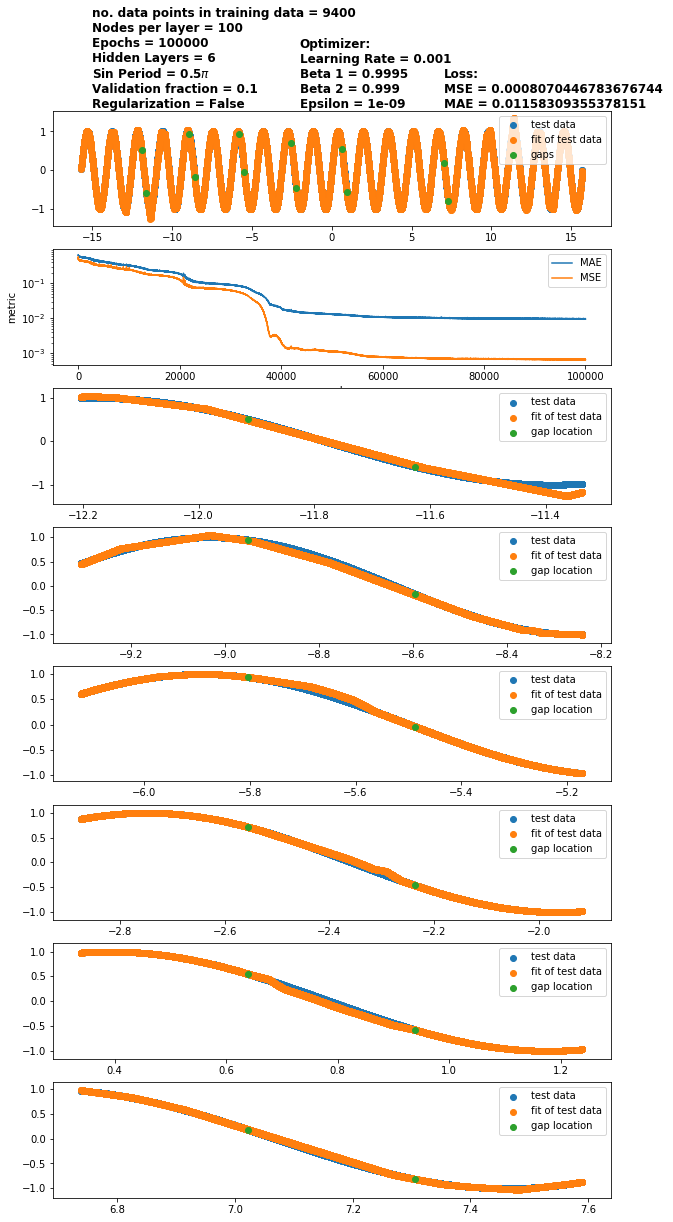

In [31]:
predictions=model.predict(np.array([x_test_data]).T,verbose=0)

gaps_x = []
gaps_y = []
gaps_set_x = []
gaps_set_y = []
for i in range(len(gap_ranges)):
    x_gap_test = np.random.rand(int(N))*(gap_ranges[i][1]-gap_ranges[i][0])+gap_ranges[i][0]
    y_gap_test = np.sin(x_gap_test*(2*np.pi/period))
    gap = [np.argmin(x_gap_test),np.argmax(x_gap_test)]
    x_min = x_gap_test[gap[0]]
    y_min = y_gap_test[gap[0]]
    x_max = x_gap_test[gap[1]]
    y_max = y_gap_test[gap[1]]
    gaps_x+=[x_min,x_max]
    gaps_set_x.append([x_min,x_max])
    gaps_y+=[y_min,y_max]
    gaps_set_y.append([y_min,y_max])
    
fig, ax = plt.subplots(2+len(gap_ranges), figsize=(10,20))
ax[0].scatter(x_test_data,y_test_data,label='test data')
ax[0].scatter(x_test_data,predictions,label='fit of test data')
#ax[0].plot(gaps_x,gaps_y,label='gaps')
ax[0].scatter(gaps_x,gaps_y,label='gaps')
ax[0].text(x=-15,y=1.6,fontsize=12,weight='bold',s='no. data points in training data = {} \nNodes per layer = {} \nEpochs = {} \nHidden Layers = {} \nSin Period = {}$\pi$ \nValidation fraction = {} \nRegularization = {}'.format(len(x_data),nodes,epochs,Hidden_layers,period/np.pi,validation_fraction,regularization))
ax[0].text(x=-2,y=1.6,fontsize=12,weight='bold',s='Optimizer:\nLearning Rate = {} \nBeta 1 = {} \nBeta 2 = {} \nEpsilon = {}'.format(learning_rate,beta_1,beta_2,epsilon))
ax[0].text(x=7,y=1.6,fontsize=12,weight='bold',s='Loss:\nMSE = {} \nMAE = {}'.format(mse,mae))
ax[0].legend(loc='upper right')

epoch_history = history.epoch
hist=history.history
MAE,MSE=hist['mae'],hist['mse']
#MAE,MSE=hist['MAE'],hist['MSE']
ax[1].plot(epoch_history,MAE,label='MAE')
ax[1].plot(epoch_history,MSE,label='MSE')
ax[1].set_yscale('log')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('metric')
ax[1].legend()

def plot_model(gaps_x,gaps_y,x2,y2,i):
    predictions=model.predict(np.array([x2]).T,verbose=0)
    #x,y= (list(t) for t in zip(*sorted(zip(x,y))))
    ax[2+i].scatter(x2,y2,label='test data')
    ax[2+i].scatter(x2,predictions,label='fit of test data')
    ax[2+i].scatter([gaps_x[i][0],gaps_x[i][1]],[gaps_y[i][0],gaps_y[i][1]],label='gap location')
    ax[2+i].legend(loc='upper right')

gap_ranges2 = []
for i in range(len(gap_ranges)):
    width = gap_ranges[i][1]-gap_ranges[i][0]
    gap_ranges2.append([gap_ranges[i][0]-width,gap_ranges[i][1]+width])
    
for i in range(len(gap_ranges)):
    x_gap_test = np.random.rand(int(N))*(gap_ranges[i][1]-gap_ranges[i][0])+gap_ranges[i][0]
    y_gap_test = np.sin(x_gap_test*(2*np.pi/period))
    
    x_gap_test2 = np.random.rand(N)*(gap_ranges2[i][1]-gap_ranges2[i][0])+gap_ranges2[i][0]
    y_gap_test2 =np.sin(x_gap_test2*(2*np.pi/period))  
    #gap_val1 = np.sin(*(2*np.pi/period))
    #gap_val2 = np.sin(gap_ranges2[i][1]*(2*np.pi/period))
    #gap_vals = [[gap_ranges2[i][0],gap_val1],[gap_ranges2[i][1],gap_val2]]
    plot_model(gaps_x=gaps_set_x,gaps_y=gaps_set_y,x2=x_gap_test2,y2=y_gap_test2,i=i)
plt.show()

#add sin period, data_range, test_range